**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import torch
import torchvision
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:3')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cpu'


In [2]:
import sys
sys.path.append("/data/ivmaksimov/igor-env/lib/python3.6/site-packages")

In [3]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset

from tqdm import trange
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, image_transform, mask_transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.aug = aug
        
    def __load_image_pair(self, idx):
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        return image, mask
        
    def __load_all_images_to_ram(self):
        self.__image_ram = []
        self.__mask_ram = []
        
        for idx in trange(len(self.images)):
            im, msk = self.__load_image_pair(idx)
            
            for var in range(self.n_variations):
                transformed_image = self.transform(im).float()
                transformed_mask = self.transform(msk).float()            
            
                self.__image_ram.append(transformed_image)
                self.__mask_ram.append(transformed_mask)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im, msk = self.__load_image_pair(idx)
        image = self.image_transform(im).float()
        mask = self.mask_transform(msk).float()   
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        return image, mask

In [5]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")

UNET_INPUT_SIZE = 380
ORIGIN_IMAGE_SIZE = 370
PADDING_INPUT = (UNET_INPUT_SIZE - ORIGIN_IMAGE_SIZE) // 2
UNET_INFERENCE_SIZE = 292
PADDING_OUTPUT_MASK = (UNET_INFERENCE_SIZE - ORIGIN_IMAGE_SIZE) // 2

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=PADDING_INPUT)
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=UNET_INFERENCE_SIZE, interpolation=torchvision.transforms.InterpolationMode.NEAREST)
])

In [6]:
train_dataset = RoadDataset(X_train, y_train, image_transform, mask_transform)

torch.Size([1, 292, 292])
tensor([0., 1.])


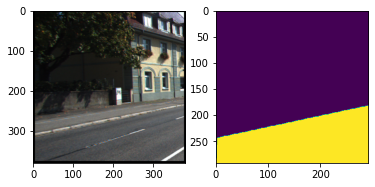

In [7]:
image, mask = train_dataset[110]

print(mask.shape)
print(torch.unique(mask))

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0).squeeze())

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [8]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [9]:
def load_test_dataset(path):
    X_test = get_paths(os.path.join(path, "images"))
    y_test = get_paths(os.path.join(path, "gt"))
          
    return RoadDataset(X_test, y_test, image_transform, mask_transform)

In [10]:
test_dataset = load_test_dataset("data/test")

In [11]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    eps = 1e-8
    intersection, union = 0, eps
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [12]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    return images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

In [13]:
def predict(model, image):
    pred_mask = model(image)
    return torch.argmax(pred_mask, dim=1)

In [139]:
def evaluate(model):
    """Returns IoU score to evaluate the segmentation model"""
    
    scores = []
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    for x_batch, y_batch in test_loader:   
        batch_cuda = x_batch.to(device)
        
        with torch.no_grad():
            pred_mask = predict(model, batch_cuda)
        
        iou_score = calc_iou(
            pred_mask.detach().cpu().numpy(), 
            y_batch.detach().cpu().numpy()
        )
        
        scores.append(iou_score)
        
        del batch_cuda, pred_mask
        torch.cuda.empty_cache()
        
    del test_loader
        
    return sum(scores) / len(scores)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__() # initialize base class to track sub-layers, parameters, etc.
        
        self.conv = nn.Conv2d(in_channels, out_channels, 3)
        self.relu = nn.ReLU()
        # self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

In [17]:
class Crop(nn.Module):
    def __init__(self, size):
        super().__init__() # initialize base class to track sub-layers, parameters, etc.
        self.size = size
        
    def forward(self, x):
        return central_crop(x, self.size)

In [65]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False, last=False):
        super().__init__() # initialize base class to track sub-layers, parameters, etc.
        self.conv1 = Conv2dBlock(in_channels, out_channels, dropout)
        self.conv2 = Conv2dBlock(out_channels, out_channels, dropout)
        self.pool = nn.MaxPool2d(2)
        
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.last = last
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.bn(x)
        x = self.conv2(x)
        
        if not self.last:
            y = self.pool(x)
        else:
            y = x
        
        return y, x

In [66]:
class UpConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__() # initialize base class to track sub-layers, parameters, etc.
        self.conv = nn.Conv2d(in_channels, out_channels * scale_factor ** 2, 3, padding=1)
        self.shuffle = nn.PixelShuffle(scale_factor)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.shuffle(x)
        return x

In [67]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, dropout=False):
        super().__init__() # initialize base class to track sub-layers, parameters, etc.
        self.upsample = UpConv2d(in_channels, mid_channels, scale_factor=2)
        self.conv1 = Conv2dBlock(mid_channels * 2, out_channels, dropout)
        self.conv2 = Conv2dBlock(out_channels, out_channels, dropout)
        
    def forward(self, x, y):
        x = self.upsample(x)        
        x = torch.cat((x, y), dim=1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [105]:
class MaskOutputBlock(nn.Module):
    def __init__(self, channels):
        super().__init__() # initialize base class to track sub-layers, parameters, etc.
        self.conv = nn.Conv2d(channels, 2, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [106]:
class UNetModel(nn.Module):
    def __init__(self):
        super().__init__() # initialize base class to track sub-layers, parameters, etc.
        self.enc1 = EncoderBlock(3, 8)
        self.enc2 = EncoderBlock(8, 16)
        self.enc3 = EncoderBlock(16, 32)
        self.enc4 = EncoderBlock(32, 64, last=True)
        
        self.crop1 = Crop(296)
        self.crop2 = Crop(152)
        self.crop3 = Crop(80)
        
        self.dec2 = DecoderBlock(64, 32, 32)
        self.dec3 = DecoderBlock(32, 16, 16)
        self.dec4 = DecoderBlock(16, 8, 8)
        
        self.out = MaskOutputBlock(8)
    
    def forward(self, x):
        x, res_x = self.enc1(x)
        x, res_y = self.enc2(x)
        x, res_z = self.enc3(x)
        x, _ = self.enc4(x)

        x = self.dec2(x, self.crop3(res_z))
        x = self.dec3(x, self.crop2(res_y))
        x = self.dec4(x, self.crop1(res_x))
        
        x = self.out(x)
        
        return x

In [129]:
criterion = nn.CrossEntropyLoss()

def balanced_segmentation_loss(ground_truth_mask, predicted_mask_probs):    
    road_thres = 0.6
    
    loss = criterion(predicted_mask_probs, ground_truth_mask.squeeze(dim=1).type(torch.LongTensor))
    road_class_volume = torch.flatten(ground_truth_mask, start_dim=1).mean(dim=1)
    
    # balance_multiplier = (1 - road_class_volume) / (road_class_volume + 1e-10)
    balance_multiplier = 1
    
    return (balance_multiplier * loss).mean()

In [130]:
torch.cuda.empty_cache()

In [131]:
loss_fn = balanced_segmentation_loss
model = UNetModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [132]:
# del model
# model = UNetModel().to(device)

In [133]:
data_loader = DataLoader(train_dataset, batch_size=4)

In [134]:
from IPython.display import clear_output
from tqdm import tqdm, trange

n_epochs = 1

metrics = {'train_loss': [], 'val_iou': [] }
step = 0

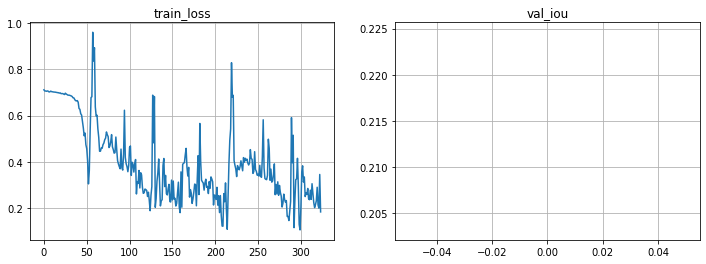

In [141]:
model.train()

for epoch in range(n_epochs):    
    loss_history = []
    average_loss = np.inf
    
    pbar = tqdm(data_loader, desc=f"epoch {epoch}")
    for x_batch, y_batch in pbar:
        cuda_batch = x_batch.to(device)
        
        opt.zero_grad()
        
        preds = model(cuda_batch)
        loss = loss_fn(y_batch.to(device), preds)
        
        metrics['train_loss'].append((step, loss.item()))
        loss_history.append(loss.item())
        average_loss = sum(loss_history) / len(loss_history)
        step += 1
        
        pbar.set_description(f"epoch {epoch} | avg. loss {average_loss}")

        loss.backward()
        opt.step()
        
        del preds, cuda_batch
        torch.cuda.empty_cache()
    
    print("Evaluating... ", end='')
    score = evaluate(model)
    print(f"score {score}")
    metrics['val_iou'].append((epoch, score))

    clear_output(wait=True)
    plt.figure(figsize=(12,4))
    for i, (name, history) in enumerate(sorted(metrics.items())):
        plt.subplot(1, len(metrics), i + 1)
        plt.title(name)
        plt.plot(*zip(*history))
        plt.grid()
    plt.show()

In [136]:
# torch.save(model.state_dict(), "model_unet.weights")

In [137]:
def show_predictions(model, image, mask):
    model.train(False)
    
    print(image.shape)
    print(mask.shape)
    
    output = model(torch.unsqueeze(image.to(device), dim=0))
    print(output.shape)
    
    print(output)

    pred_probas = central_crop(output, 370)
    pred = torch.argmax(pred_probas, dim=1)

    crop = transforms.CenterCrop(370)

    plt.subplot(1, 3, 1)
    plt.imshow(crop(image).permute(1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(crop(mask).permute(1, 2, 0).squeeze())
    plt.subplot(1, 3, 3)
    plt.imshow(pred.detach().cpu().permute(1, 2, 0).squeeze())

torch.Size([3, 380, 380])
torch.Size([1, 292, 292])
torch.Size([1, 2, 292, 292])
tensor([[[[ 0.9010,  0.9269,  1.4092,  ...,  4.4361,  6.5505,  2.4597],
          [ 0.4965,  0.6645,  1.1088,  ...,  4.0958,  5.5677,  3.0889],
          [ 0.8351,  1.0174,  1.4922,  ...,  5.4261,  7.1984,  3.4792],
          ...,
          [ 0.7086,  1.0465,  1.7364,  ..., -0.0377, -0.0341, -0.0326],
          [ 1.1275,  1.5772,  2.1721,  ..., -0.0207, -0.0210, -0.0273],
          [-0.1104, -0.0566,  0.1467,  ..., -0.0162, -0.0249, -0.0169]],

         [[-0.5865, -0.5916, -0.1131,  ..., -2.9486, -0.0217, -2.2096],
          [-0.4775, -0.7209, -0.4042,  ..., -3.3381, -2.0072, -2.9576],
          [-0.4615, -0.3862,  0.0287,  ..., -1.8203,  0.4715, -1.9950],
          ...,
          [-0.6897, -1.0365, -0.4668,  ...,  0.0465,  0.0400,  0.0656],
          [-0.6149, -0.4266,  0.1508,  ...,  0.0358,  0.0308,  0.0672],
          [ 0.1855,  0.2833,  0.3865,  ...,  0.0540,  0.0550,  0.0823]]]],
       grad_fn=<Mkld

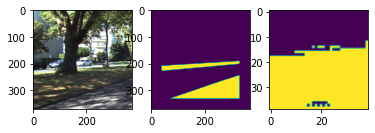

In [146]:
image, mask = train_dataset[9]
show_predictions(model, image, mask)